<a href="https://colab.research.google.com/github/igorcavalcante/MVP_machine_learning_e_analytics/blob/master/estrelas_variaveis_nao_uniformes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP: *Machine Learning & Analytics*
**Autor:** Igor Raphael Lins Cavalcante

**Data:** 22/08/2025

**Matrícula:** 4052025001876

**Dataset:**: Dados coletados  de www.aavso.org da estrela Betelgeuse entre 2001 e 2024


## 1. Escopo, objetivo e definição do problema
Ao longo dos anos vários astrônomos amadores contribuem com dados científicos relevantes em diversas áreas. Á area de estudo é neste notebook é a de estrelas variáveis não uniformes (**brilho varia de maneira não uniforme no decorrer do tempo**). A  estrela estudada em questão é Betelgeuse, a estrela mais brilhante da constelação de Órion e que eventualmente explodirá transformando-se assim em uma supernova.

O desafio é prever a variabilidade da estrela usando **séries temporais com janelas de 30 dias em um modelo LSTM**. Como a estrela fica próxima do sol durante alguns meses do ano a coleta de dados fica difícil nessas épocas, também há dados faltantes e dados com determinado grau de incerteza.
**Nesse momento gostaria de salientar que ainda não paguei o Sprint que aborda a limpeza de dados. Foi tentada a melhor abordagem dentro as minhas limitações**
  
### Área de aplicação
Sensores / Séries temporais astronômicas (dados observacionais).  

### Valor agregado
Com este tipo de iniciativa podemos ter uma previsão melhor sobre o comportamento estelar, detectar precocemente anomalias, apoiar e colaborar mais ativamente em publicações científicas.

## 2. Reprodutibilidade e ambiente

In [1]:
# Dependências
!pip install -q astropy
!pip install -q matplotlib
!pip install -q pandas numpy
!pip install -q keras
!pip install -q scikit-learn

In [2]:
# Setup básico e reprodutibilidade
import os
import json

from astropy.time import Time

import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf, keras

from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Flatten, Dropout, Bidirectional, LayerNormalization
from keras.callbacks import History

import matplotlib.pyplot as plt

In [3]:
# Funções utilitárias

# Baseline naive pra comparar os dados com o modelo principal
# retorna o mse
def naive_baseline(X_test, Y_test):
    y_pred = X_test[:, -1]
    errors = (Y_test - y_pred) ** 2
    return np.mean(errors)

# Histograma pra verificar a distribuição dos dados de acordo com o tempo
def plot_histogram(df):
    dfMes= data["DataHora"].dt.month
    dfMes.hist(bins=12, figsize=(10,5))
    plt.xlabel("Mês")
    plt.ylabel("Frequência")
    plt.title("Histograma dos dados por mês")
    plt.show()

# 3. Dados: carga, entendimento e qualidade

In [4]:
# carregando os dados vindos do aavso
data = pd.read_csv('https://raw.githubusercontent.com/igorcavalcante/MVP_machine_learning_e_analytics/refs/heads/master/alpha_ori_2001_2024.csv')

print(f"Total de registros: {len(data)}")
data.head()

Total de registros: 26917


,JD,Magnitude,Uncertainty,HQuncertainty,Band,Observer Code,Comment Code(s),Comp Star 1,Comp Star 2,Charts,...,Cmag,Kmag,HJD,Star Name,Observer Affiliation,Measurement Method,Grouping Method,ADS Reference,Digitizer,Credit
0,2.451912e+06,0.8,NaN,NaN,Vis.,TDB,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,ALF ORI,NaN,STD,NaN,NaN,NaN,NaN
1,2.451912e+06,1.0,NaN,NaN,Vis.,MOW,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,ALF ORI,NaN,STD,NaN,NaN,NaN,NaN
2,2.451912e+06,0.6,NaN,NaN,Vis.,AAP,NaN,05,11,SA3/68,...,NaN,NaN,NaN,ALF ORI,NaN,STD,NaN,NaN,NaN,NaN
3,2.451912e+06,0.7,NaN,NaN,Vis.,TKK,M,04,12,SVSO,...,NaN,NaN,NaN,ALF ORI,NaN,STD,NaN,NaN,NaN,NaN
4,2.451912e+06,0.5,NaN,NaN,Vis.,EER,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,ALF ORI,NaN,STD,NaN,NaN,NaN,NaN


## 3.1 Análise exploatória
__Ressaltando que neste ponto que eu não paguei as disciplinas que cobrem análise exploratória de dados. Tentei o melhor resultado dentro as minhas limitações__

> O tratamento de outliers foi realizado de maneira mínima, além de não me sentir seguro para fazer o mesmo de maneira adequada, é uma característica específica dessa estrela ter uns picos de brilho fora do padrão. Espera-se que eventualmente ela explodirá em uma Supernova

In [ ]:
# Só precisarei da data, magnitude e incerteza
data = data.iloc[:, [0,1,2]]

# adicionando a data para o calendário gregoriano
data.loc[:, "DataHora"] = data["JD"].apply(lambda d: Time(d, format='jd').iso)

## transformando os campos de data para os histogramas
data["DataHora"] = pd.to_datetime(data["DataHora"], errors="coerce")
data["Data"] = pd.to_datetime(data["DataHora"]).dt.date

# transformando os valores que são NaN na incerteza em 0.0, pois são os menores valores possíveis
data.loc[:, "Uncertainty"] = data["Uncertainty"].fillna(0.0)

# mudando a magnitude pra float
data.loc[:,"Magnitude"] = data["Magnitude"].str.replace("<", "", regex=False).astype(float)
data["Magnitude"] = pd.to_numeric(data["Magnitude"], errors="coerce")
data.head()

,JD,Magnitude,Uncertainty,DataHora,Data
0,2.451912e+06,0.8,0.0,2001-01-02 01:30:00.000,2001-01-02
1,2.451912e+06,1.0,0.0,2001-01-02 02:24:00.000,2001-01-02
2,2.451912e+06,0.6,0.0,2001-01-02 07:12:00.000,2001-01-02
3,2.451912e+06,0.7,0.0,2001-01-02 19:56:55.680,2001-01-02
4,2.451912e+06,0.5,0.0,2001-01-02 22:12:00.000,2001-01-02


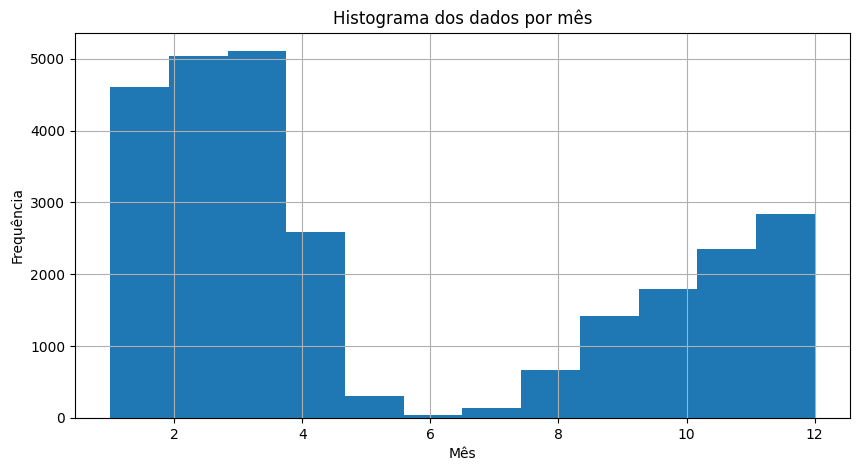

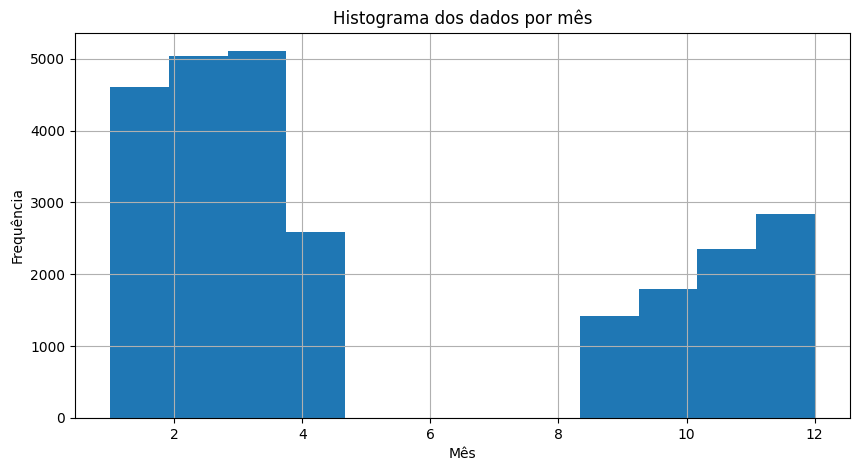

In [ ]:
# plotando os dados do histograma vemos que em algums meses temos mais observações e em outros menos
# um dos motivos disto acontecer pela proximidade da estrela em questão pelo sol
plot_histogram(data)

# analisando os dados do histograma e fazendo uma pesquisa descobri que o as observações ficam praticamente inviáveis entre os meses de maio e  agosto. Vou retirar estes meses do dataset
data = data[~data["DataHora"].dt.month.between(5, 8)]
plot_histogram(data)

In [ ]:
# Agrupando as  medições por dia e mantendo somente a com menor grau de incerteza

# analisando a incerteza para ver como posso descartar as entradas duplicadas  no mesmo dia
# Percebe-se que há dados  com até 60% de incerteza
print("Dados antes do agrupamento:")
print(data["Uncertainty"].describe(), "\n")

# Quero somente uma medição por dia
# Utilizarei sempre a medição com menor incerteza daquele dia
grouped = data.groupby("Data")
grouped
idx = grouped["Uncertainty"].idxmin()

byDay = data.loc[idx].sort_values("Data").reset_index(drop=True)

# O dado com maior incerteza agora é de 4.4% e temos somente uma entrada por dia
# A média e desvio padrão também caíram muito
print("Dados depoois do agrupamento:")
print(byDay["Uncertainty"].describe(), "\n")
print(f"Total de dias presentes: {len(byDay)}")

Dados antes do agrupamento:
count    25768.000000
mean         0.002395
std          0.014063
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.600000
Name: Uncertainty, dtype: float64 

Dados depoois do agrupamento:
count    5137.000000
mean        0.000072
std         0.001162
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.044000
Name: Uncertainty, dtype: float64 

Total de dias presentes: 5137


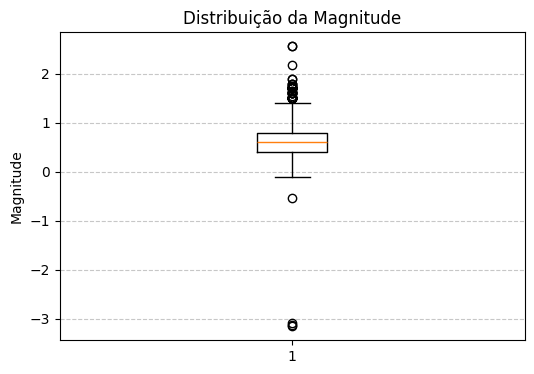

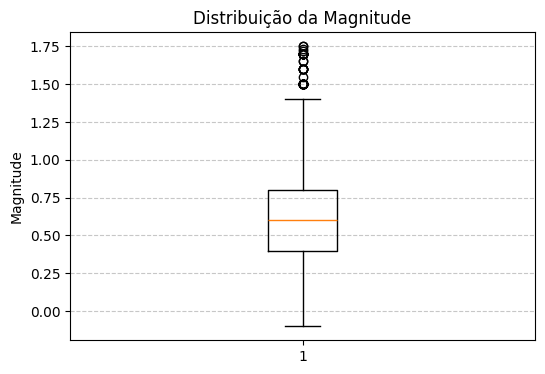

In [ ]:
# Identificando possíveis outliers
plt.figure(figsize=(6, 4))
plt.boxplot(byDay["Magnitude"], vert=True)
plt.title("Distribuição da Magnitude")
plt.ylabel("Magnitude")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)

plt.show()

# Fazendo um ajuste bem conservador para interferir o mínimo na base de dados original
byDayClean = byDay.copy()
byDayClean["Magnitude"] = byDay["Magnitude"].mask((byDay["Magnitude"] < -0.5) | (byDay["Magnitude"] > 1.75))

plt.figure(figsize=(6, 4))
plt.boxplot(byDayClean["Magnitude"].dropna(), vert=True)
plt.title("Distribuição da Magnitude")
plt.ylabel("Magnitude")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)

plt.show()

byDay = byDayClean

In [ ]:
# Analisando os dias faltantes que não estejam próximos a janela em que o astro se encontra próximo ao sol
# e fazendo uma interpolação linear nesses dias para manter uma completude dos dados

# Verificando quantos dias não tiveram medições e não estão entre  os meses de maio e agosto
rangetoToCompare = pd.date_range(
    start=byDay["Data"].min(),
    end=byDay["Data"].max(),
    freq="D"
)

# Filtrar os meses de allDays, não de data
mask = ~((rangetoToCompare.month >= 5) & (rangetoToCompare.month <= 8))
rangetoToCompare = rangetoToCompare[mask]

missingDays = rangetoToCompare.difference(byDay["Data"].unique())

print(f"Total de dias faltantes: {len(missingDays)}")

# Completando interpolando nos dias que não tiveram medições, desde que não estejam entre os meses entre maio e agosto
dataInterpolated = byDay.set_index("Data").reindex(rangetoToCompare).rename_axis("Data").reset_index()
dataInterpolated["Magnitude"] = dataInterpolated["Magnitude"].interpolate(method="linear")

dataInterpolated

Total de dias faltantes: 676


,Data,JD,Magnitude,Uncertainty,DataHora
0,2001-01-02,2.451912e+06,0.8,0.0,2001-01-02 01:30:00.000
1,2001-01-03,2.451913e+06,0.7,0.0,2001-01-03 04:05:57.120
2,2001-01-04,2.451914e+06,0.5,0.0,2001-01-04 23:12:02.880
3,2001-01-05,2.451915e+06,0.5,0.0,2001-01-05 19:50:00.960
4,2001-01-06,2.451916e+06,0.7,0.0,2001-01-06 00:00:00.000
...,...,...,...,...,...
5808,2024-12-27,2.460672e+06,0.9,0.0,2024-12-27 02:19:58.080
5809,2024-12-28,2.460673e+06,0.5,0.0,2024-12-28 14:55:58.080
5810,2024-12-29,2.460674e+06,0.9,0.0,2024-12-29 03:36:00.000
5811,2024-12-30,2.460675e+06,0.3,0.0,2024-12-30 19:12:00.000


In [ ]:
# Agora vamos preencher os dados entre os meses de maio e agosto com
# valores de magnitude 0 mais na frente criaremos uma máscara binária para melhorar a performance do LSTM

rangeToInclude = pd.date_range(
    start=dataInterpolated["Data"].min(),
    end=dataInterpolated["Data"].max(),
    freq="D"
)

missingDays = rangeToInclude.difference(dataInterpolated["Data"].unique())
print(f"Total de dias faltantes: {len(missingDays)}")

# Completando os  dados e colocando zero nos valores de magnitude que estão nulos
dataComplete = dataInterpolated.set_index("Data").reindex(rangeToInclude).rename_axis("Data").reset_index()
dataComplete.loc[:, "Magnitude"] = dataComplete["Magnitude"].fillna(0.0)

print(f"Total de dias onde o campo data é nulo: {dataComplete["Magnitude"].isna().sum()}")

Total de dias faltantes: 2952
Total de dias onde o campo data é nulo: 0


# 4. Definição do target, variáveis e divisão de dados

In [ ]:
# Iniciando a geração das janelas temporais

# Reescalando os dados
mmscaler = MinMaxScaler((-1.0, 1.0))
mags = mmscaler.fit_transform(dataComplete[["Magnitude"]]).squeeze()

# Criando a máscara binária para ajudar nos períodos faltantes
mask = (~np.isnan(mags)).astype(int)
Y = np.stack([mags, mask], axis=1).astype(np.float32)

print(f"Tamanho dos dados: {Y.shape}\n")

# O número mais próximo divisível por 30 para deixar as janelas bem ajustadas
N = 8760
Y = Y[:N]
nb_samples = N
sequence_length = 30


# Geração das janelas já dividindo os dados em dados  de  treino e dados de testes!
n_seq = nb_samples - sequence_length      # total de janelas possíveis
n_test_targets = 600                      # 600 elementos (alvos) no teste
split = n_seq - n_test_targets            # Corte das janelas

X_ts = np.zeros((n_seq, sequence_length, 2), dtype=np.float32)
Y_ts = np.zeros((n_seq, 1), dtype=np.float32)

for i in range(n_seq):
    X_ts[i] = Y[i:i+sequence_length]
    Y_ts[i] = Y[i + sequence_length, 0]

X_ts_train, Y_ts_train = X_ts[:split], Y_ts[:split, 0]
X_ts_test,  Y_ts_test  = X_ts[split:],  Y_ts[split:, 0]

print("PROBLEM_TYPE: Serie Temporal")
print("Target: Magnitude")
print("N features: 2 (Magnitude a máscara binária)")

Tamanho dos dados: (8765, 2)

PROBLEM_TYPE: Serie Temporal
Target: Magnitude
N features: 2 (Magnitude a máscara binária)


## 5. Treino e avaliação  (inclindo baseline)

In [ ]:
# Baixando os modelos localmente
!wget -4 --no-check-certificate "https://raw.githubusercontent.com/igorcavalcante/MVP_machine_learning_e_analytics/master/simple_star_model.keras"
!wget -4 --no-check-certificate "https://raw.githubusercontent.com/igorcavalcante/MVP_machine_learning_e_analytics/master/star_model.keras"
!wget -4 --no-check-certificate "https://raw.githubusercontent.com/igorcavalcante/MVP_machine_learning_e_analytics/master/main_model_history.json"
!wget -4 --no-check-certificate "https://raw.githubusercontent.com/igorcavalcante/MVP_machine_learning_e_analytics/master/simple_model_history.json"

--2025-09-26 14:15:32--  https://raw.githubusercontent.com/igorcavalcante/MVP_machine_learning_e_analytics/master/simple_star_model.keras
Carregou certificado CA "/etc/ssl/certs/ca-certificates.crt"
Resolvendo raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Conectando-se a raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 200 OK
Tamanho: 30699 (30K) [application/octet-stream]
Salvando em: “simple_star_model.keras”

simple_star_model.k 100%[===================>]  29,98K  --.-KB/s    em 0,01s   

2025-09-26 14:15:33 (2,80 MB/s) - “simple_star_model.keras” salvo [30699/30699]

--2025-09-26 14:15:33--  https://raw.githubusercontent.com/igorcavalcante/MVP_machine_learning_e_analytics/master/star_model.keras
Carregou certificado CA "/etc/ssl/certs/ca-certificates.crt"
Resolvendo raw.githubusercontent.com (raw.githubusercontent.com)... 18

In [ ]:
results = {}

# comparando com naive (baseline)
naive_mse = naive_baseline(X_ts_test[:,0], Y_ts_test)
results["baseline"] = {"loss": np.nan, "mae": np.nan, "mse": naive_mse}
print(f"O mse baseline é: {naive_mse:.4f}\n")

simple_model_path = "simple_star_model.keras"
url = "https://raw.githubusercontent.com/igorcavalcante/MVP_machine_learning_e_analytics/master/simple_star_model.keras"

# if not os.path.exists(simple_model_path):
#    print("Baixando modelo simples... ")
#    r = requests.get(url, stream=True)
#    r.raise_for_status()

#    with open("simple_star_model.keras", "wb") as f:
#        for chunk in r.iter_content(chunk_size=8192):
#            if chunk:
#                f.write(chunk)

#    print("Download concluído!")


if os.path.exists(simple_model_path):
    print("Modelo Simples já existe, carregando...")
    simple_model = keras.models.load_model(simple_model_path)

else:
    print("Modelo não encontrado, treinando do zero...")

    # modelo LSTM simples com 50 épocas
    simple_model = Sequential([
        Input(batch_size=30, shape=(sequence_length, 2)),
        LSTM(8, stateful=True),
        Flatten(),
        Dense(1)
    ])

    simple_model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=["mae", "mse"])

    simple_model_history = simple_model.fit(X_ts_train, Y_ts_train,
      batch_size=30,
      epochs=50,
      shuffle=False,
      validation_data=(X_ts_test, Y_ts_test),
    )

    simple_model.save(simple_model_path)
    with open("simple_model_history.json", "w") as f:
        json.dump(simple_model_history.history, f)

    print("Modelo salvo!")

simple_loss, simple_mae, simple_mse = simple_model.evaluate(X_ts_test, Y_ts_test, verbose=0, batch_size=30)
results["LSTM simples"] = {"loss": simple_loss, "mae": simple_mae, "mse": simple_mse}
print(f"Resultados do modelo simples ---> loss: {simple_loss}, mae: {simple_mae}, mse: {simple_mse}\n")

# Modelo principal. Mais pesado, por isso já foi salvo
main_model_path = "star_model.keras"

if os.path.exists(main_model_path):
    print("Modelo já existe, carregando...")
    main_model = keras.models.load_model(main_model_path)

else:
    print("Modelo não encontrado, treinando do zero...")

    main_model = Sequential([
        Input(shape=(sequence_length, 2)),
        Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.1)),
        LayerNormalization(),
        LSTM(64, dropout=0.2, recurrent_dropout=0.1),
        Dense(32, activation="relu"),
        Dropout(0.1),
        Dense(1)
    ])

    callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                     patience=64,
                                     restore_best_weights=True)
    ]

    steps_per_epoch = len(X_ts_train) // 256
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=steps_per_epoch,
        decay_rate=0.98,
        staircase=True
    )

    opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0)
    main_model.compile(optimizer=opt, loss=tf.keras.losses.Huber(delta=1.0), metrics=["mae", "mse"])

    main_model_history = main_model.fit(X_ts_train, Y_ts_train,
      batch_size=256,
      epochs=200,
      shuffle=False,
      validation_data=(X_ts_test, Y_ts_test),
      callbacks=callbacks
    )

    main_model.save(main_model_path)
    with open("main_model_history.json", "w") as f:
        json.dump(main_model_history.history, f)

    print("Modelo salvo!")

main_loss, main_mae, main_mse = main_model.evaluate(X_ts_test, Y_ts_test, verbose=0, batch_size=30)
results["LSTM principal"] = {"loss": main_loss, "mae": main_mae, "mse": main_mse}
print(f"Resultados do modelo principal ---> loss: {main_loss}, mae: {main_mae}, mse: {main_mse}\n")

O mse baseline é: 2.4817

Modelo Simples já existe, carregando...
Resultados do modelo simples ---> loss: 0.02097041718661785, mae: 0.09328453987836838, mse: 0.02097041718661785

Modelo já existe, carregando...
Resultados do modelo principal ---> loss: 0.010613588616251945, mae: 0.1000557616353035, mse: 0.02122717723250389



# 6. Avaliação, análise de erros e limitações
O modelo LSTM simplificado e com menos épocas teve uma performance baseada em MSE ligeiramente melhor do que o modelo mais complexo e com mais épocas.
Uma clara demonstração de que nem sempre o que é mais complexo e demora mais pra ser treinado é o que pode ter o melhor retorno.

> Uma observação interessante é de que  o modelo aprendeu muito rápido nas primeiras épocas e depois estabilizou bastente. Isto é demonstrado em um dos gráficos abaixo

In [ ]:
results = pd.DataFrame(results).T
results["mse_ratio"] = naive_mse / results["mse"]
results

,loss,mae,mse,mse_ratio
baseline,NaN,NaN,2.481694,1.000000
LSTM simples,0.020970,0.093285,0.020970,118.342591
LSTM principal,0.010614,0.100056,0.021227,116.911141


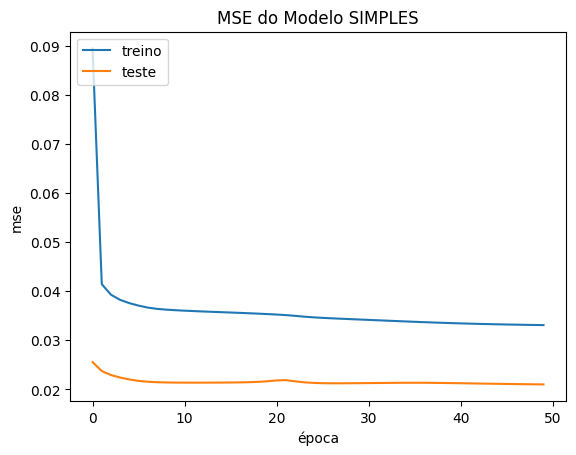

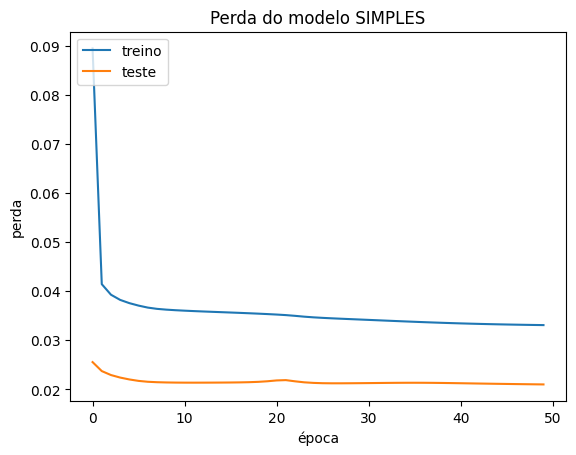

In [ ]:
with open("simple_model_history.json", "r") as f:
    history_dict = json.load(f)

simple_model_history = History()
simple_model_history.history = history_dict

# plotamos o erro calculado a partir do histórico
plt.plot(simple_model_history.history['mse'])  # erro médio quadrático (treinamento)
plt.plot(simple_model_history.history['val_mse']) # erro médio quadrático (teste)
plt.title('MSE do Modelo SIMPLES')
plt.ylabel('mse')
plt.xlabel('época')
plt.legend(['treino', 'teste'], loc='upper left')
plt.show()

# plotamos o erro/perda a partir do histórico
plt.plot(simple_model_history.history['loss']) # perda/erro durante o treinamento
plt.plot(simple_model_history.history['val_loss']) #perda/erro durante a validação (teste)
plt.title('Perda do modelo SIMPLES')
plt.ylabel('perda')
plt.xlabel('época')
plt.legend(['treino', 'teste'], loc='upper left')
plt.show()

# 6.1 Análise dos resultados do modelo

271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step


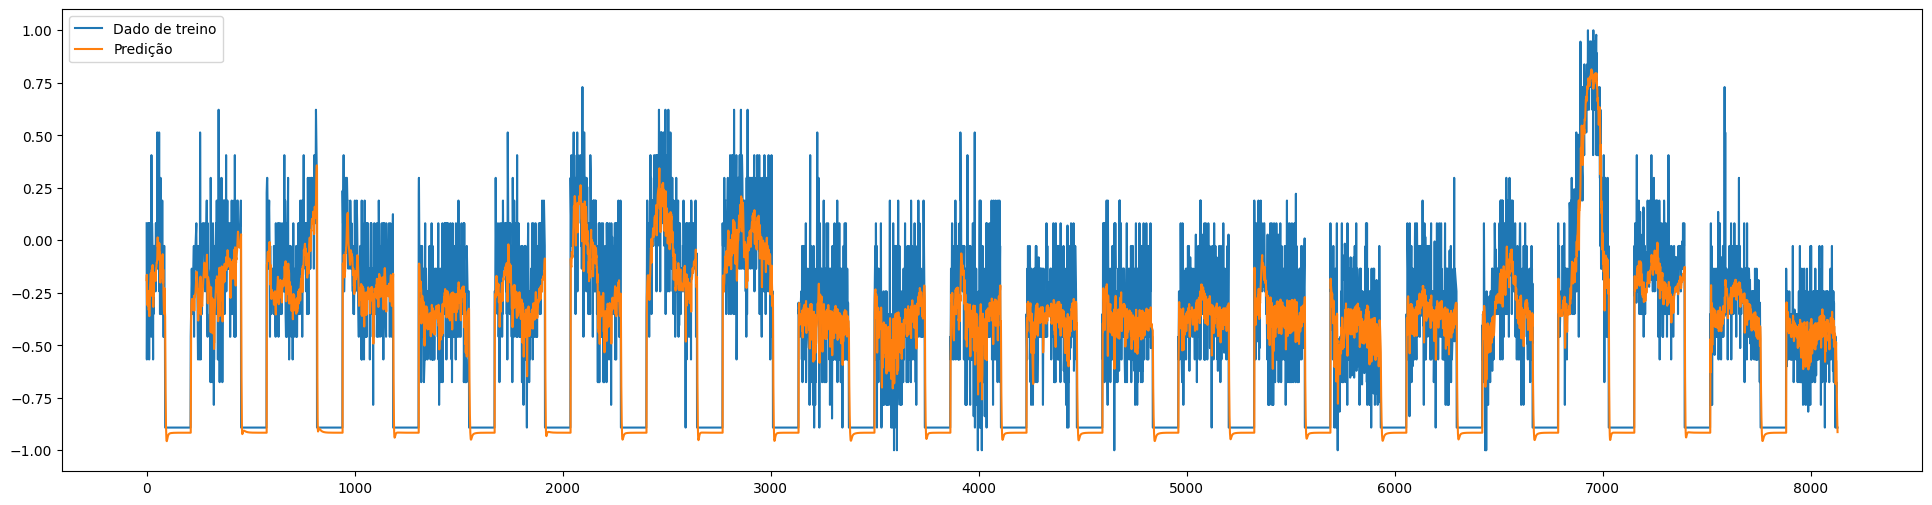

In [ ]:
# Visualizando os dados reais de treino X os dados preditos de treino
plt.figure(figsize=(24, 6))
plt.plot(Y_ts_train)
plt.plot(simple_model.predict(X_ts_train, batch_size=30)) #plota dados resultantes
plt.legend(['Dado de treino', 'Predição'], loc='upper left')
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


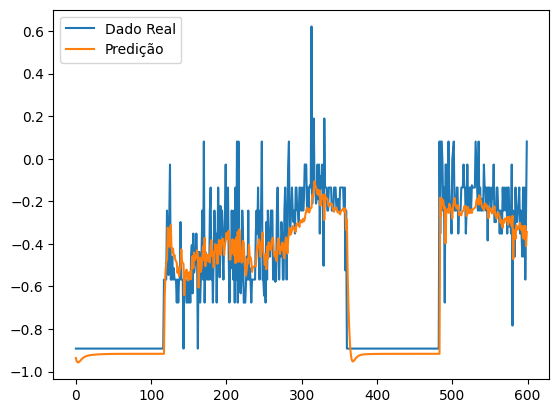

In [ ]:
# Visualizando os dados reais de validação X os dados preditos de validação
plt.plot(Y_ts_test)
plt.plot(simple_model.predict(X_ts_test, batch_size=30))
plt.legend(['Dado Real', 'Predição'], loc='upper left')
plt.show()

# 7 Conclusões e próximos passos
- De acordo com a análise dos resultados, as predições acompanharam bem os resultados reais, inclusive nos períodos entre maio e agosto, onde há um gap de coletas.
- Outro ponto interessante é de que as predições estão sempre mais voltadas ao centro da distribuição em relação aos dados reais

## 7.1 Próximos passos
Poderíamos pegar esses dados de uma agência que não depender somente de astronomos amadores, assim teríamos mais precisão e completude das informações.
Fazer um estudo mais aprofundado dos dados para avaliar melhor a possibilidade de cortar os outliers.
Utilizar dados de sondas espaciais para não nos limitarmos aos períodos que a estrela está afastada do sol, inclusive com informações de parte do espectro não visível, como Raios-X, ultravioleta e inframvermelho por exemplo.